In [ ]:
#export
from nb_006a import *
from concurrent.futures import ProcessPoolExecutor

# Camvid

## Setup

In [ ]:
PATH = Path('data/camvid')
PATH_X = PATH/'701_StillsRaw_full'
PATH_Y = PATH/'LabeledApproved_full'
PATH_Y_PROCESSED = PATH/'LabelProcessed'
label_csv = PATH/'label_colors.txt'

PATH_Y_PROCESSED.mkdir(exist_ok=True)

In [ ]:
list(PATH_Y.iterdir())[0]

PosixPath('data/camvid/LabeledApproved_full/0016E5_08109_L.png')

In [ ]:
def get_y_fn(x_fn): return PATH_Y/f'{x_fn.name[:-4]}_L.png'
def get_y_proc_fn(y_fn): return PATH_Y_PROCESSED/f'{y_fn.name[:-6]}_P.png'

In [ ]:
x_fns = get_image_files(PATH_X)
y_fns = [get_y_fn(o) for o in x_fns]
y_proc_fns = [get_y_proc_fn(o) for o in y_fns]
x_fns[:3],y_fns[:3],y_proc_fns[:3]

([PosixPath('data/camvid/701_StillsRaw_full/Seq05VD_f02220.png'),
  PosixPath('data/camvid/701_StillsRaw_full/0016E5_08550.png'),
  PosixPath('data/camvid/701_StillsRaw_full/0001TP_007260.png')],
 [PosixPath('data/camvid/LabeledApproved_full/Seq05VD_f02220_L.png'),
  PosixPath('data/camvid/LabeledApproved_full/0016E5_08550_L.png'),
  PosixPath('data/camvid/LabeledApproved_full/0001TP_007260_L.png')],
 [PosixPath('data/camvid/LabelProcessed/Seq05VD_f02220_P.png'),
  PosixPath('data/camvid/LabelProcessed/0016E5_08550_P.png'),
  PosixPath('data/camvid/LabelProcessed/0001TP_007260_P.png')])

In [ ]:
def parse_code(l):
    a,b = [c for c in l.strip().split("\t") if c]
    return tuple(int(o) for o in a.split(' ')), b

In [ ]:
label_codes,label_names = zip(*[parse_code(l) for l in open(PATH/"label_colors.txt")])
label_t = tensor(label_codes)
n_labels = len(label_codes)
label_codes[:5],label_names[:5], n_labels

(((64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)),
 ('Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'),
 32)

In [ ]:
name2code = dict(zip(label_names, label_codes))
name2id = {v:k for k,v in enumerate(label_names)}
void_code = name2id['Void']

code2id = ByteTensor(255,255,255).zero_()+void_code
for i,code in enumerate(label_codes):
    if not code == void_code: code2id[code]=i

In [ ]:
def colors_to_codes(color_data):
    n = len(color_data)
    idxs = tuple(color_data.reshape(n,-1).long())
    return code2id[idxs].view(color_data.shape[1:])

In [ ]:
i = 0
x_img = open_image(x_fns[i])
y_img_mask = open_mask(y_fns[i])
y_img = Image(y_img_mask.data.int())

In [ ]:
y_code = colors_to_codes(y_img.data)

In [ ]:
def codes_to_colors(label_data):
    h,w = label_data.shape
    idxs = label_data.flatten().long()
    return Image(label_t.index_select(0, idxs).reshape(h,w,3).permute(2,0,1))

In [ ]:
y_img2 = codes_to_colors(y_code)

(None, None)

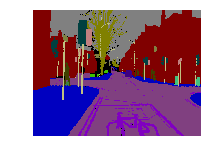

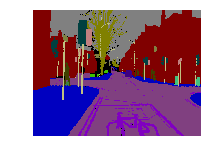

In [ ]:
y_img.show(), y_img2.show()

In [ ]:
def process_file(fns):
    yfn, pfn = fns
    if not pfn.exists():
        y_data = open_mask(yfn).px.long()
        proc_data = colors_to_codes(y_data)
        img = PIL.Image.fromarray(proc_data.numpy())
        img.save(pfn)
    return pfn

def process_label_files(y_fns, y_proc_fns):
    ex = ProcessPoolExecutor(16)
    for pfn in ex.map(process_file, zip(y_fns, y_proc_fns)):
        pass

In [ ]:
%time process_label_files(y_fns, y_proc_fns)

CPU times: user 396 ms, sys: 260 ms, total: 656 ms
Wall time: 39.1 s


In [ ]:
def get_datasets(path, valid_pct=0.2):
    x_fns = get_image_files(path)
    y_fns = [get_y_fn(o) for o in x_fns]
    y_proc_fns = [get_y_proc_fn(o) for o in y_fns]
    total = len(x_fns)
    
    train, valid = random_split(valid_pct, x_fns, y_proc_fns)
    return (MatchedImageDataset(*train), MatchedImageDataset(*valid))

In [ ]:
def get_tfm_datasets(size):
    datasets = get_datasets(PATH_X)
    tfms = get_transforms(do_flip=True, max_rotate=4, max_lighting=0.2)
    return transform_datasets(*datasets, tfms=tfms, tfm_y=True, size=size)

In [ ]:
default_norm,default_denorm = normalize_funcs(*imagenet_stats)
bs = 8
size = 512

In [ ]:
tfms = get_transforms(do_flip=True, max_rotate=4, max_lighting=0.2)

In [ ]:
def get_data(size, bs):
    return DataBunch.create(*get_tfm_datasets(size), bs=bs, tfms=default_norm)

In [ ]:
data = get_data(size, bs)

In [ ]:
x, y = data.train_ds[0]
x.shape, y.shape, y.data.dtype

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]), torch.int64)

## Unet

In [ ]:
def accuracy_no_void(input, target):
    target = target.squeeze()
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
accuracy_no_void(p,y)

tensor(0.7114, device='cuda:0')

In [ ]:
metrics=[accuracy_no_void]
lr = 1e-3

In [ ]:
body = create_body(tvm.resnet34(True), 2)
model = DynamicUnet(body, n_classes=len(label_codes)).cuda()
learn = Learner(data, model, metrics=metrics, loss_fn=CrossEntropyFlat())
learn.split([model[0][6], model[1]])
learn.freeze()

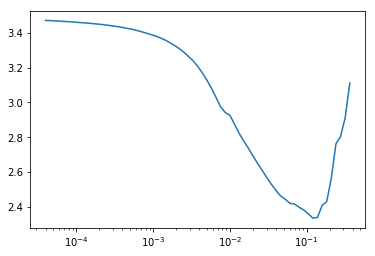

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(6, slice(lr), pct_start=0.05)

Total time: 02:55
epoch  train loss  valid loss
0      1.144465    1.669415    (00:28)
1      0.827026    0.767053    (00:29)
2      0.702947    0.656885    (00:29)
3      0.644283    0.570501    (00:29)
4      0.598689    0.517745    (00:28)
5      0.575997    0.510366    (00:29)



In [ ]:
learn.save('u0')

In [ ]:
learn.load('u0')
x,y = next(iter(learn.data.valid_dl))
py = learn.model(x).detach()
py = py.softmax(dim=1).max(dim=1, keepdim=True)[1]
x,y,py = x.cpu(),y.cpu(),py.cpu()
x = default_denorm(x)

In [ ]:
n = 4
fig, axs = plt.subplots(n,3,figsize=(10,10), sharey=True)
for i in range(n):
    Image(x[i]).show(ax=axs[i][0])
    codes_to_image(y[i].numpy()).show(ax=axs[i][1])
    codes_to_image(py[i].numpy()).show(ax=axs[i][2])

In [ ]:
learn.unfreeze()
lr=1e-2

In [ ]:
learn.fit_one_cycle(6, slice(lr/100,lr), pct_start=0.05)

In [ ]:
size=640
bs = 4
learn.data = get_data(size, bs)

In [ ]:
#learn.freeze()

In [ ]:
learn.fit_one_cycle(6, slice(lr), pct_start=0.05)

In [ ]:
id2code

## Fin